In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shapefile as shp
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import scipy
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

import sklearn
from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint
import time

In [2]:
# import data
df_drybean = pd.read_excel('Dry_Bean_Dataset.xlsx')
df_drybean

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


Observation - A total of 13611 rows and 16 features are present.

In [3]:
# Checking for missing values
df_drybean.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

Observation - There are no omitted values

In [4]:
# getting data summary
df_drybean.describe(percentiles=[.25, .5, .75, 0.995]).T

,count,mean,std,min,25%,50%,75%,99.5%,max
Area,13611.0,53048.284549,29324.095717,20420.000000,36328.000000,44652.000000,61332.000000,200711.400000,254616.000000
Perimeter,13611.0,855.283459,214.289696,524.736000,703.523500,794.941000,977.213000,1716.395500,1985.370000
MajorAxisLength,13611.0,320.141867,85.694186,183.601165,253.303633,296.883367,376.495012,651.184245,738.860153
MinorAxisLength,13611.0,202.270714,44.970091,122.512653,175.848170,192.431733,217.031741,401.341128,460.198497
AspectRation,13611.0,1.583242,0.246678,1.024868,1.432307,1.551124,1.707109,2.247550,2.430306
Eccentricity,13611.0,0.750895,0.092002,0.218951,0.715928,0.764441,0.810466,0.895566,0.911423
ConvexArea,13611.0,53768.200206,29774.915817,20684.000000,36714.500000,45178.000000,62294.000000,203371.050000,263261.000000
EquivDiameter,13611.0,253.064220,59.177120,161.243764,215.068003,238.438026,279.446467,505.523186,569.374358
Extent,13611.0,0.749733,0.049086,0.555315,0.718634,0.759859,0.786851,0.831485,0.866195
Solidity,13611.0,0.987143,0.004660,0.919246,0.985670,0.988283,0.990013,0.993305,0.994677


In [5]:
# displaying the unique dry beans
df_drybean['Class'].unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

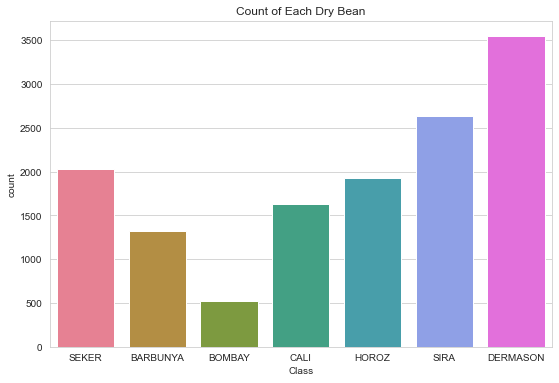

In [6]:
# count of each dry bean.
plt.figure(figsize=(9,6))
sns.set_style("whitegrid")
sns.countplot(x='Class', data=df_drybean,palette = 'husl')
plt.title('Count of Each Dry Bean')
plt.show()

In [7]:
# exact count of each dry bean
print('Count of each dry bean:')
df_drybean['Class'].value_counts()

Count of each dry bean:


DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

Observation - As can be seen from the count plot, this is an unbalanced classification problem.

In [8]:
# creating a copy of df_drybean
df_drybean1 = df_drybean
df_drybean1

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


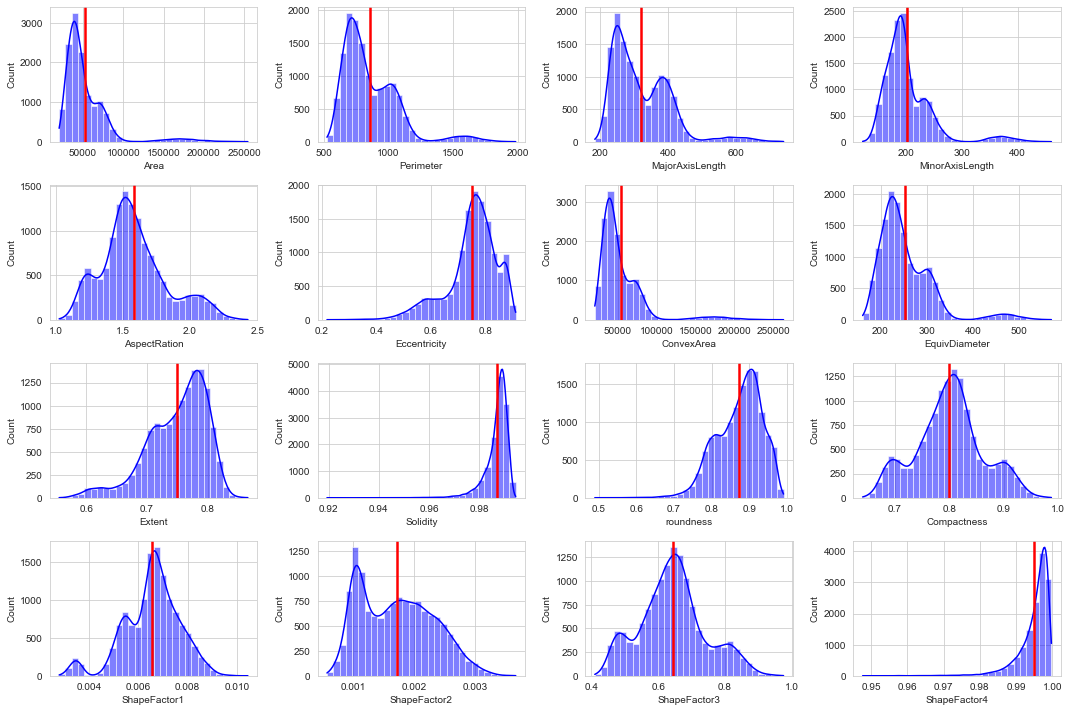

In [9]:
# distribution of dry bean parameters in the data
parameters= df_drybean1.drop(columns=['Class']).columns
fig, ax = plt.subplots(4,4, figsize=(15, 10))
axes_list = ax.flatten()
for parameter, subplot in zip(parameters, axes_list):
    mean = df_drybean1[parameter].mean()
    ax=sns.histplot(df_drybean1[parameter],bins=30,kde=True, ax=subplot, color = 'blue')
    ax.axvline(mean,color ='red', linewidth=2.5)
plt.tight_layout()

Observation - Numerous characteristics exhibit skewness and outliers in their distributions; these points may resemble a distinct class of dried beans.The distribution of each characteristic among the dry bean classes should be investigated.

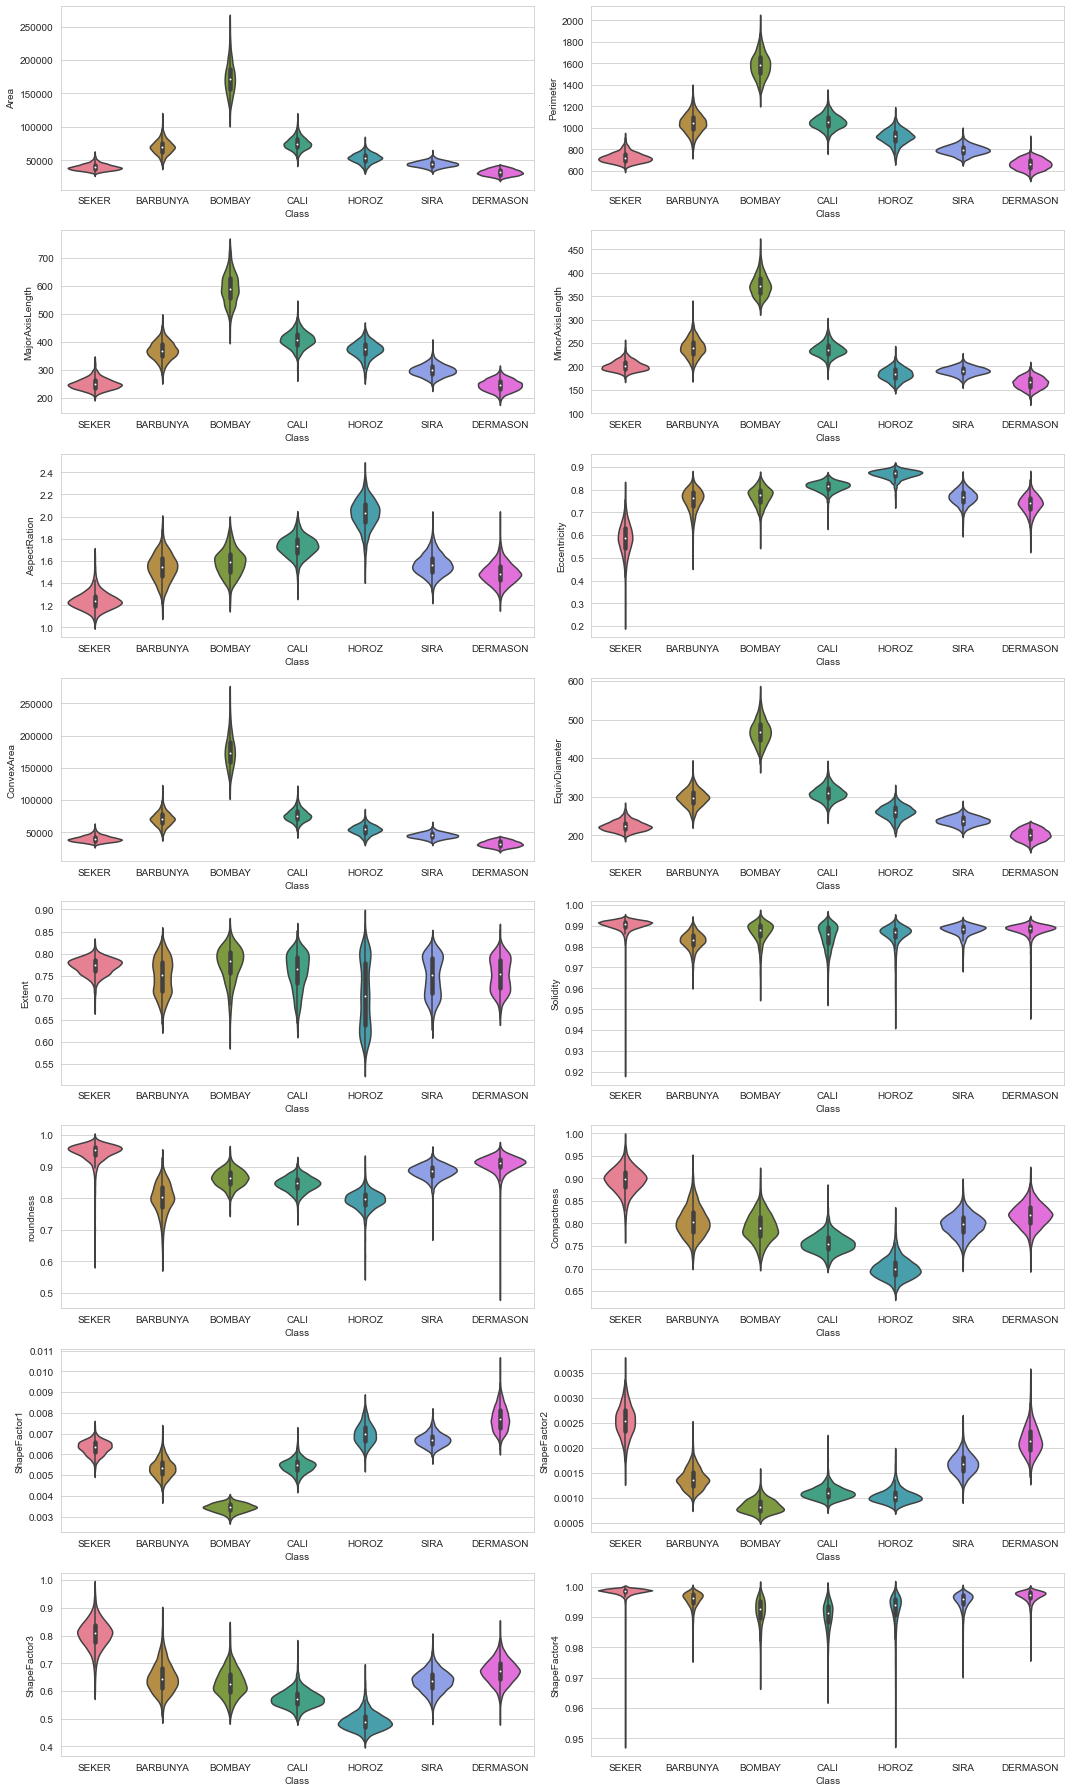

In [10]:
# distribution of dry bean parameters using violin plot in the data
fig, ax = plt.subplots(8, 2, figsize=(15, 25))
for parameter, subplot in zip(parameters, ax.flatten()):
    sns.violinplot(x=df_drybean1['Class'], y= df_drybean1[parameter], ax=subplot,palette = 'husl')
plt.tight_layout()

Observation - The Bombay class is significantly different from the other classes; it has a wider area and perimeter and can be easily differentiated from the other classes by its Minor Axis Length and Shape Factor 1 values. Dermason class shares some characteristics with Seker class and some with Sira class. It may be challenging to appropriately label this class. Certain characteristics have a highly skewed distribution with lengthy tails.

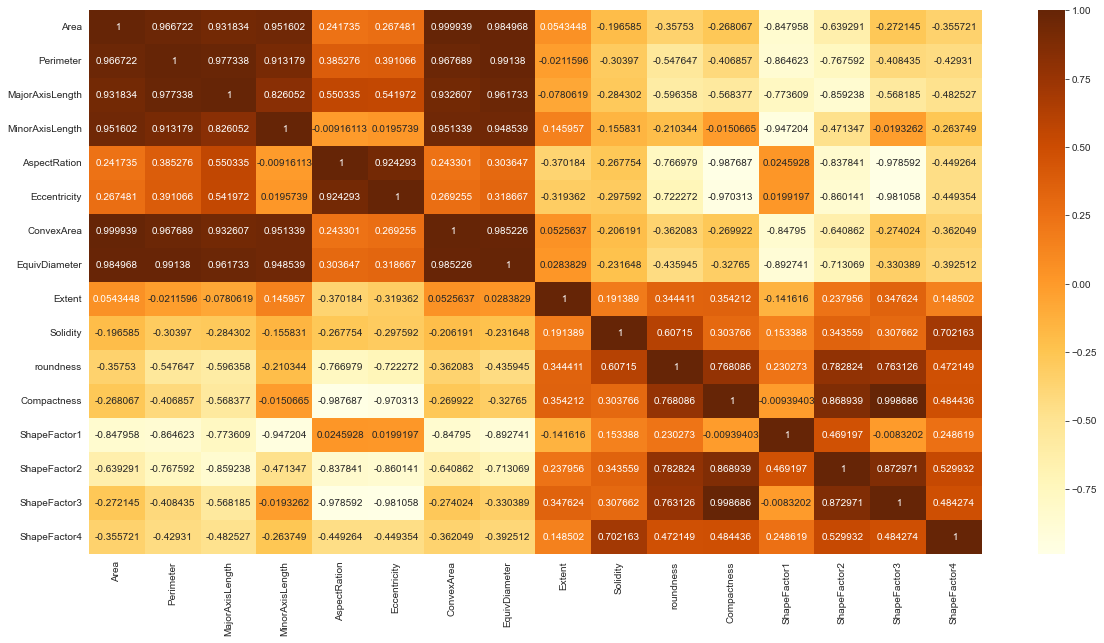

In [11]:
# plotting correlation matrix
corr_mat = df_drybean1.corr()
fig = plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,annot=True,cmap = 'YlOrBr' ,fmt="2g")
plt.show()

Observation - There are a lot of linearly correlated features

In [12]:
# encoding the class column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_drybean1['Class'] = label_encoder.fit_transform(df_drybean1.Class)
df_drybean1

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,3
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,3
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,3
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,3


In [13]:
# separating inputs and outputs
X = df_drybean1.iloc[:,0:-1]
y = df_drybean1.iloc[:,-1]

In [14]:
# Split into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [15]:
# converting the data in to array
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
# wrapping the data in tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [111]:
import pickle

In [113]:
# exporting df_drybean1
with open('pickle_files/df_drybean1.pickle', 'wb') as output:
    pickle.dump(df_drybean1, output)

In [114]:
# exporting X_train
with open('pickle_files/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)

In [115]:
# exporting y_train
with open('pickle_files/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)

In [116]:
# exporting X_test
with open('pickle_files/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)

In [117]:
# exporting y_test
with open('pickle_files/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)

In [17]:
# parameters of the network
input_size = len(X.columns) 
hidden = 30  
num_classes = 7                 
dropout = 0.3
activation = F.relu

In [18]:
# base mlp model
class MLP(nn.Module):
     def __init__(self, input_size = input_size, 
         hidden = hidden, output_size = num_classes, dropout = dropout,
         activation = activation
     ):
            
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [19]:
# using Adam optimizer for scaled data
optimizer = optim.Adam
# using cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

# used default parameters
torch.manual_seed(0)
net = NeuralNetClassifier(MLP, max_epochs = 10, optimizer = optimizer,
    criterion = criterion,lr = 0.01,iterator_train__shuffle = True, 
    callbacks = [EpochScoring(scoring='accuracy', lower_is_better=False),
                 EarlyStopping(monitor='valid_loss', patience=10, lower_is_better=True)]
)

net.fit(X_train,y_train);

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1938        1.9740       0.1938        1.9717  1.6548
      2      0.1938        1.9716       0.1938        1.9717  0.4879
      3      0.1938        1.9718       0.1938        1.9717  0.4466
      4      0.1938        1.9717       0.1938        1.9717  0.4418
      5      0.1938        1.9717       0.1938        1.9717  0.4374
      6      0.1938        1.9717       0.1938        1.9717  0.4505
      7      0.1938        1.9717       0.1938        1.9717  0.4424
      8      0.1938        1.9717       0.1938        1.9717  0.4547
      9      0.1938        1.9718       0.1938        1.9717  0.4524
     10      0.1938        1.9718       0.1938        1.9717  0.4506


In [20]:
# training accuracy of mlp model
mlp_train_accuracy = accuracy_score(y_train, net.predict(X_train))
print("MLP training accuracy: ", mlp_train_accuracy)

MLP training accuracy:  0.19369948567229978


Observation - The training accuracy for the data without scaling is poor so it is necessary to apply scaling to the dataset

In [21]:
# testing accuracy of mlp model
mlp_test_accuracy = accuracy_score(y_test, net.predict(X_test))
print("MLP testing accuracy: ", mlp_test_accuracy)

MLP testing accuracy:  0.1935365405802424


Observation - The testing accuracy for the data without scaling is poor so it is necessary to apply scaling to the dataset

In [22]:
# scaling the dataset
from sklearn.preprocessing import MinMaxScaler
df_drybean2 = df_drybean1
df_drybean2 = df_drybean2.drop('Class',axis=1)
scaling = MinMaxScaler()
names = df_drybean2.columns
df_scaled = scaling.fit_transform(df_drybean1[['Area', 'Perimeter', 'MajorAxisLength','MinorAxisLength', 'AspectRation', 'Eccentricity',
    'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity','roundness', 'Compactness', 'ShapeFactor1',
    'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']])
scaled_df = pd.DataFrame(df_scaled, columns=names)
scaled_df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,0.034053,0.058574,0.044262,0.152142,0.122612,0.477797,0.033107,0.070804,0.671024,0.922824,0.934823,0.786733,0.593432,0.833049,0.750996,0.980620
1,0.035500,0.077557,0.030479,0.178337,0.051577,0.278472,0.034991,0.073577,0.735504,0.871514,0.793138,0.903549,0.547447,0.967315,0.884987,0.974979
2,0.038259,0.068035,0.052633,0.158190,0.131521,0.496448,0.037126,0.078816,0.716671,0.932141,0.914511,0.773514,0.582016,0.800942,0.736200,0.987196
3,0.040940,0.082942,0.048548,0.177691,0.091623,0.403864,0.041389,0.083854,0.731365,0.761614,0.826871,0.829912,0.552408,0.854744,0.799846,0.893675
4,0.041504,0.065313,0.032862,0.200679,0.025565,0.165680,0.040123,0.084906,0.700538,0.949832,0.988408,0.951583,0.510741,1.000000,0.941770,0.989116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.092559,0.160862,0.189318,0.187843,0.375584,0.788553,0.089967,0.172180,0.512286,0.942381,0.852151,0.465175,0.531785,0.382135,0.412185,0.974113
13607,0.092576,0.159358,0.176450,0.201964,0.321303,0.746241,0.089910,0.172207,0.786890,0.947954,0.862952,0.523974,0.509582,0.426233,0.470848,0.970912
13608,0.092739,0.160605,0.176384,0.203370,0.318558,0.743877,0.090219,0.172463,0.561689,0.936648,0.855785,0.525351,0.508683,0.427019,0.472240,0.943025
13609,0.092773,0.163657,0.179703,0.200669,0.330472,0.753971,0.090623,0.172517,0.482741,0.908991,0.834795,0.510145,0.514216,0.415330,0.456919,0.913342


In [23]:
# concatinating the the class column with the scaled data
df_drybean_scaled = pd.concat([scaled_df,df_drybean1['Class']],axis=1)
df_drybean_scaled

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,0.034053,0.058574,0.044262,0.152142,0.122612,0.477797,0.033107,0.070804,0.671024,0.922824,0.934823,0.786733,0.593432,0.833049,0.750996,0.980620,5
1,0.035500,0.077557,0.030479,0.178337,0.051577,0.278472,0.034991,0.073577,0.735504,0.871514,0.793138,0.903549,0.547447,0.967315,0.884987,0.974979,5
2,0.038259,0.068035,0.052633,0.158190,0.131521,0.496448,0.037126,0.078816,0.716671,0.932141,0.914511,0.773514,0.582016,0.800942,0.736200,0.987196,5
3,0.040940,0.082942,0.048548,0.177691,0.091623,0.403864,0.041389,0.083854,0.731365,0.761614,0.826871,0.829912,0.552408,0.854744,0.799846,0.893675,5
4,0.041504,0.065313,0.032862,0.200679,0.025565,0.165680,0.040123,0.084906,0.700538,0.949832,0.988408,0.951583,0.510741,1.000000,0.941770,0.989116,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.092559,0.160862,0.189318,0.187843,0.375584,0.788553,0.089967,0.172180,0.512286,0.942381,0.852151,0.465175,0.531785,0.382135,0.412185,0.974113,3
13607,0.092576,0.159358,0.176450,0.201964,0.321303,0.746241,0.089910,0.172207,0.786890,0.947954,0.862952,0.523974,0.509582,0.426233,0.470848,0.970912,3
13608,0.092739,0.160605,0.176384,0.203370,0.318558,0.743877,0.090219,0.172463,0.561689,0.936648,0.855785,0.525351,0.508683,0.427019,0.472240,0.943025,3
13609,0.092773,0.163657,0.179703,0.200669,0.330472,0.753971,0.090623,0.172517,0.482741,0.908991,0.834795,0.510145,0.514216,0.415330,0.456919,0.913342,3


In [24]:
# separating inputs and outputs for scaled data
X_sc = df_drybean_scaled.iloc[:,0:-1]
y_sc = df_drybean_scaled.iloc[:,-1]

In [25]:
# Split into training set and test set for scaled data
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.2, stratify=y_sc, random_state=10)

In [26]:
# converting the data in to array for scaled data
X_train_sc, y_train_sc = np.array(X_train_sc), np.array(y_train_sc)
X_test_sc, y_test_sc = np.array(X_test_sc), np.array(y_test_sc)

In [27]:
# wrapping the data in tensors
X_train_sc = torch.from_numpy(X_train_sc).float()
y_train_sc = torch.from_numpy(y_train_sc).long()
X_test_sc = torch.from_numpy(X_test_sc).float()
y_test_sc = torch.from_numpy(y_test_sc).long()

In [118]:
# exporting df_drybean_scaled
with open('pickle_files/df_drybean_scaled.pickle', 'wb') as output:
    pickle.dump(df_drybean_scaled, output)

In [119]:
# exporting X_train scaled
with open('pickle_files/X_train_sc.pickle', 'wb') as output:
    pickle.dump(X_train_sc, output)

In [120]:
# exporting y_train scaled
with open('pickle_files/y_train_sc.pickle', 'wb') as output:
    pickle.dump(y_train_sc, output)

In [121]:
# exporting X_test scaled
with open('pickle_files/X_test_sc.pickle', 'wb') as output:
    pickle.dump(X_test_sc, output)

In [122]:
# exporting y_test scaled
with open('pickle_files/y_test_sc.pickle', 'wb') as output:
    pickle.dump(y_test_sc, output)

In [28]:
# parameters of the network for scaled data
input_size = len(X_sc.columns) 
hidden = 30  
num_classes = 7                 
dropout = 0.3
activation = F.relu

In [29]:
# mlp model for scaled data
class MLP_sc(nn.Module):
     def __init__(self, input_size = input_size, 
         hidden = hidden, output_size = num_classes, dropout = dropout,
         activation = activation
     ):
            
        super(MLP_sc, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [30]:
# using Adam optimizer for scaled data
optimizer = optim.Adam
# using cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

# used default parameters for scaled data
torch.manual_seed(0)
net_sc = NeuralNetClassifier(MLP_sc, max_epochs = 10, optimizer = optimizer,
    criterion = criterion,lr = 0.01,iterator_train__shuffle = True, 
    callbacks = [EpochScoring(scoring='accuracy', lower_is_better=False),
                 EarlyStopping(monitor='valid_loss', patience=10, lower_is_better=True)]
)

net_sc.fit(X_train_sc,y_train_sc);

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.6809        1.7567       0.6809        1.5301  0.4196
      2      0.8287        1.4920       0.8287        1.3461  0.4027
      3      0.8343        1.4001       0.8343        1.3388  0.4466
      4      0.8333        1.3950       0.8333        1.3343  0.4573
      5      0.8407        1.3671       0.8407        1.3257  0.4206
      6      0.8540        1.3592       0.8540        1.3124  0.4556
      7      0.8471        1.3534       0.8471        1.3145  0.4205
      8      0.8549        1.3483       0.8549        1.3109  0.3969
      9      0.8577        1.3566       0.8577        1.3084  0.4145
     10      0.8572        1.3462       0.8572        1.3089  0.4225


In [31]:
# training accuracy of mlp model for scaled data
mlp_train_accuracy_sc = accuracy_score(y_train_sc, net_sc.predict(X_train_sc))
print("MLP training accuracy for scaled data: ", mlp_train_accuracy_sc)

MLP training accuracy for scaled data:  0.8550698016164585


Observation - The training accuracy is increased tremendously after scaling the data 

In [32]:
# testing accuracy of mlp model for scaled data
mlp_test_accuracy_sc = accuracy_score(y_test_sc, net_sc.predict(X_test_sc))
print("MLP testing accuracy for scaled data: ", mlp_test_accuracy_sc)

MLP testing accuracy for scaled data:  0.8494307748806463


Observation - The testing accuracy is increased tremendously after scaling the data

In [33]:
# applying smote to train scaled data
from imblearn.over_sampling import SMOTE
from collections import Counter
X_train_sm, y_train_sm = SMOTE().fit_resample(X_train_sc, y_train_sc)
print(sorted(Counter(y_train_sm).items()))

[(0, 2837), (1, 2837), (2, 2837), (3, 2837), (4, 2837), (5, 2837), (6, 2837)]


In [123]:
# exporting X_train smote
with open('pickle_files/X_train_sm.pickle', 'wb') as output:
    pickle.dump(X_train_sm, output)

In [124]:
# exporting y_train scaled
with open('pickle_files/y_train_sm.pickle', 'wb') as output:
    pickle.dump(y_train_sm, output)

In [34]:
# applying smote to test scaled data
from imblearn.over_sampling import SMOTE
from collections import Counter
X_test_sm, y_test_sm = SMOTE().fit_resample(X_test_sc, y_test_sc)
print(sorted(Counter(y_test_sm).items()))

[(0, 709), (1, 709), (2, 709), (3, 709), (4, 709), (5, 709), (6, 709)]


In [125]:
# exporting X_test smote
with open('pickle_files/X_test_sm.pickle', 'wb') as output:
    pickle.dump(X_test_sm, output)

In [126]:
# exporting y_test smote
with open('pickle_files/y_test_sm.pickle', 'wb') as output:
    pickle.dump(y_test_sm, output)

In [35]:
# used default parameters for scaled data with smote
torch.manual_seed(0)
net_sc = NeuralNetClassifier(MLP_sc, max_epochs = 10, optimizer = optimizer,
    criterion = criterion,lr = 0.01,iterator_train__shuffle = True, 
    callbacks = [EpochScoring(scoring='accuracy', lower_is_better=False),
                 EarlyStopping(monitor='valid_loss', patience=10, lower_is_better=True)]
)

net_sc.fit(X_train_sm, y_train_sm);

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8708        1.6163       0.8708        1.3099  0.6818
      2      0.8741        1.3836       0.8741        1.2965  0.7402
      3      0.8834        1.3458       0.8834        1.2851  0.7001
      4      0.8759        1.3261       0.8759        1.2884  0.7054
      5      0.8960        1.3241       0.8960        1.2729  0.6886
      6      0.8958        1.3151       0.8958        1.2684  0.7097
      7      0.8973        1.3060       0.8973        1.2681  0.7214
      8      0.8824        1.3023       0.8824        1.2815  0.6987
      9      0.9018        1.3074       0.9018        1.2627  0.7183
     10      0.8628        1.2929       0.8628        1.3015  0.7626


In [36]:
# training accuracy of mlp model for scaled data after applying smote
mlp_train_accuracy_sc_sm = accuracy_score(y_train_sc, net_sc.predict(X_train_sc))
print("MLP training accuracy for scaled data with smote: ", mlp_train_accuracy_sc_sm)

MLP training accuracy for scaled data with smote:  0.8513960323291697


Observation - The training accuracy is further increased when smote is applied

In [37]:
# testing accuracy of mlp model for scaled data after applying smote
mlp_test_accuracy_sc_sm = accuracy_score(y_test_sc, net_sc.predict(X_test_sc))
print("MLP testing accuracy for scaled data with smote: ", mlp_test_accuracy_sc_sm)

MLP testing accuracy for scaled data with smote:  0.8464928387807565


Observation - The testing accuracy is further increased when smote is applied

In [38]:
#  mlp random grid search train side
net_sc.set_params()
params = {'lr': [0.0001,0.001, 0.01],'batch_size':[32,64,128],'optimizer':[optim.Adam, optim.SGD],
    'max_epochs': [300,400,500],'mod__hidden': [50,100,150],'mod__dropout': [0.1, 0.3],
    'mod__activation':[F.relu, F.selu]}

random_search_mlp_train= RandomizedSearchCV(net_sc, params, refit=False, cv=5 ,scoring='accuracy')

random_search_mlp_train.fit(X_train_sm, y_train_sm);

print("best parameters: {}".format(random_search_mlp_train.best_params_))

best parameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'mod__hidden': 100, 'mod__dropout': 0.1, 'mod__activation': <function selu at 0x0000026A43891790>, 'max_epochs': 300, 'lr': 0.0001, 'batch_size': 64}


In [40]:
#  mlp random grid search test side
net_sc.set_params()
params = {'lr': [0.0001,0.001, 0.01],'batch_size':[32,64,128],'optimizer':[optim.Adam, optim.SGD],
    'max_epochs': [300,400,500],'mod__hidden': [50,100,150],'mod__dropout': [0.1, 0.3],
    'mod__activation':[F.relu, F.selu]}

random_search_mlp_test= RandomizedSearchCV(net_sc, params, refit=False, cv=5 ,scoring='accuracy')

random_search_mlp_test.fit(X_test_sm, y_test_sm);

print("best parameters: {}".format(random_search_mlp_test.best_params_))

best parameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'mod__hidden': 50, 'mod__dropout': 0.1, 'mod__activation': <function selu at 0x0000026A43891790>, 'max_epochs': 500, 'lr': 0.0001, 'batch_size': 32}


In [41]:
# mlp grid search train side
net_sc.set_params()
params = {'lr': [0.0001,0.001, 0.01],'batch_size':[32,64,128],'optimizer':[optim.Adam, optim.SGD],
    'max_epochs': [300,400,500],'mod__hidden': [50,100,150],'mod__dropout': [0.1, 0.3],
    'mod__activation':[F.relu, F.selu]}

grid_search_mlp_train= GridSearchCV(net_sc, params, refit=False, cv=5 ,scoring='accuracy')

grid_search_mlp_train.fit(X_train_sm, y_train_sm);

print("best parameters: {}".format(grid_search_mlp_train.best_params_))

best parameters: {'batch_size': 32, 'lr': 0.0001, 'max_epochs': 300, 'mod__activation': <function relu at 0x0000026A438914C0>, 'mod__dropout': 0.1, 'mod__hidden': 50, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [42]:
# mlp grid search test side
net_sc.set_params()
params = {'lr': [0.0001,0.001, 0.01],'batch_size':[32,64,128],'optimizer':[optim.Adam, optim.SGD],
    'max_epochs': [300,400,500],'mod__hidden': [50,100,150],'mod__dropout': [0.1, 0.3],
    'mod__activation':[F.relu, F.selu]}

grid_search_mlp_test= GridSearchCV(net_sc, params, refit=False, cv=5 ,scoring='accuracy')

grid_search_mlp_test.fit(X_test_sm, y_test_sm);

print("best parameters: {}".format(grid_search_mlp_test.best_params_))

best parameters: {'batch_size': 32, 'lr': 0.0001, 'max_epochs': 300, 'mod__activation': <function relu at 0x0000026A438914C0>, 'mod__dropout': 0.1, 'mod__hidden': 50, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [43]:
# building mlp model based on best parameters received after grid search
# parameters of the network
input_size = len(X_sc.columns) 
hidden = 50  
num_classes = 7               
dropout = 0.1
activation = F.relu

# best parameters botained from grid search
batch_size = 32
lr = 0.0001
epochs = 300
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss

# final mlp model
class final_mlp(nn.Module):
     def __init__(self, input_size = input_size, 
         hidden = hidden, output_size = num_classes, dropout = dropout,
         activation = activation
     ):
            
        super(final_mlp, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [44]:
# using parameters obtained from grid search
torch.manual_seed(0)
net_final_train = NeuralNetClassifier(final_mlp, max_epochs = epochs, optimizer = optimizer,
    criterion = criterion,lr = lr,iterator_train__shuffle = True, 
    callbacks = [EpochScoring(scoring='accuracy', lower_is_better=False),
                 EarlyStopping(monitor='valid_loss', patience=5, lower_is_better=True)])
start_time_train = time.time()
net_final_train.fit(X_train_sm,y_train_sm);
stop_time_train = time.time() - start_time_train

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2470        1.9428       0.2470        1.9386  0.7490
      2      0.4464        1.9326       0.4464        1.9233  0.7213
      3      0.4869        1.9094       0.4869        1.8881  0.7035
      4      0.4126        1.8590       0.4126        1.8216  0.7475
      5      0.4539        1.7915       0.4539        1.7546  0.6903
      6      0.5023        1.7330       0.5023        1.7005  0.7356
      7      0.5385        1.6880       0.5385        1.6617  0.6711
      8      0.5607        1.6534       0.5607        1.6272  0.6923
      9      0.6427        1.6199       0.6427        1.5890  0.7540
     10      0.6843        1.5850       0.6843        1.5516  0.7184
     11      0.7379        1.5534       0.7379        1.5183  0.7020
     12      0.7714        1.5219       0.7714        1.4873  0.7930
     13      0.8270        1.4944 

In [144]:
# exporting final mlp model train side
with open('final_models/mlp_final_train.pickle', 'wb') as output:
    pickle.dump(net_final_train, output)

In [45]:
# using parameters obtained from grid search
torch.manual_seed(0)
net_final_test = NeuralNetClassifier(final_mlp, max_epochs = epochs, optimizer = optimizer,
    criterion = criterion,lr = lr,iterator_train__shuffle = True, 
    callbacks = [EpochScoring(scoring='accuracy', lower_is_better=False),
                 EarlyStopping(monitor='valid_loss', patience=5, lower_is_better=True)])
start_time_test = time.time()
net_final_test.fit(X_test_sm,y_test_sm);
stop_time_test = time.time() - start_time_test

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1420        1.9453       0.1420        1.9444  0.1804
      2      0.1420        1.9437       0.1420        1.9428  0.1921
      3      0.1420        1.9422       0.1420        1.9411  0.1919
      4      0.1752        1.9405       0.1752        1.9391  0.1851
      5      0.3595        1.9382       0.3595        1.9366  0.1882
      6      0.4270        1.9357       0.4270        1.9337  0.1948
      7      0.4350        1.9326       0.4350        1.9303  0.1914
      8      0.4491        1.9291       0.4491        1.9259  0.1803
      9      0.5247        1.9242       0.5247        1.9206  0.1862
     10      0.5347        1.9188       0.5347        1.9144  0.1925
     11      0.4965        1.9121       0.4965        1.9070  0.2040
     12      0.5045        1.9046       0.5045        1.8985  0.1821
     13      0.4975        1.8951 

In [145]:
# exporting final mlp model
with open('final_models/mlp_final_test.pickle', 'wb') as output:
    pickle.dump(net_final_test, output)

In [46]:
# training time for mlp model
print('Training time for MLP :',stop_time_train)

Training time for MLP : 173.79133915901184


In [47]:
# testing time for mlp model
print('Testing time for MLP :',stop_time_test)

Testing time for MLP : 44.821792125701904


In [49]:
# classification training report of the mlp model
class_report_train_mlp = classification_report(y_train_sm,net_final_train.predict(X_train_sm))
print(class_report_train_mlp)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2837
           1       1.00      1.00      1.00      2837
           2       0.93      0.92      0.92      2837
           3       0.89      0.92      0.90      2837
           4       0.96      0.96      0.96      2837
           5       0.96      0.96      0.96      2837
           6       0.86      0.85      0.86      2837

    accuracy                           0.93     19859
   macro avg       0.93      0.93      0.93     19859
weighted avg       0.93      0.93      0.93     19859



In [50]:
# classification testing report of the mlp model
class_report_test_mlp = classification_report(y_test_sm,net_final_test.predict(X_test_sm))
print(class_report_test_mlp)

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       709
           1       1.00      1.00      1.00       709
           2       0.79      0.83      0.81       709
           3       0.90      0.86      0.88       709
           4       0.97      0.92      0.94       709
           5       0.94      0.94      0.94       709
           6       0.80      0.90      0.85       709

    accuracy                           0.89      4963
   macro avg       0.89      0.89      0.89      4963
weighted avg       0.89      0.89      0.89      4963



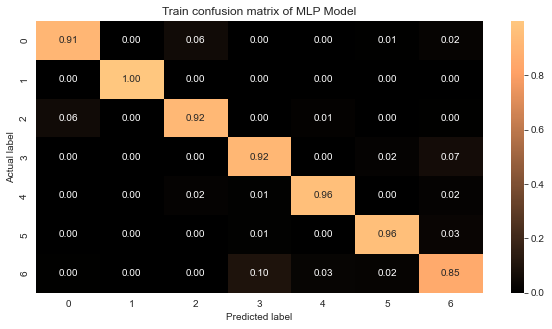

In [51]:
# Train confusion matrix of the mlp model
fig = plt.figure(figsize=(10,5))
con_matrix_train = confusion_matrix(y_train_sm, net_final_train.predict(X_train_sm))
# normalizing the data
con_matrix_train = con_matrix_train / np.sum(con_matrix_train, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_train,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Train confusion matrix of MLP Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

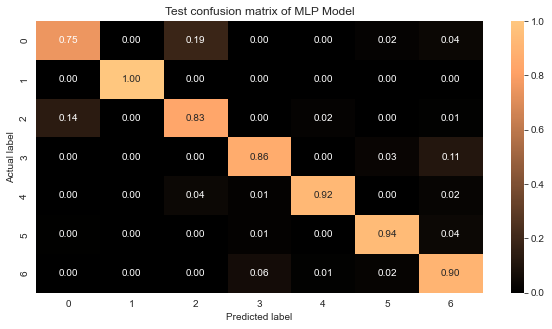

In [52]:
# Test confusion matrix of the mlp model
fig = plt.figure(figsize=(10,5))
con_matrix_test = confusion_matrix(y_test_sm, net_final_test.predict(X_test_sm))
# normalizing the data
con_matrix_test = con_matrix_test / np.sum(con_matrix_test, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_test,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Test confusion matrix of MLP Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

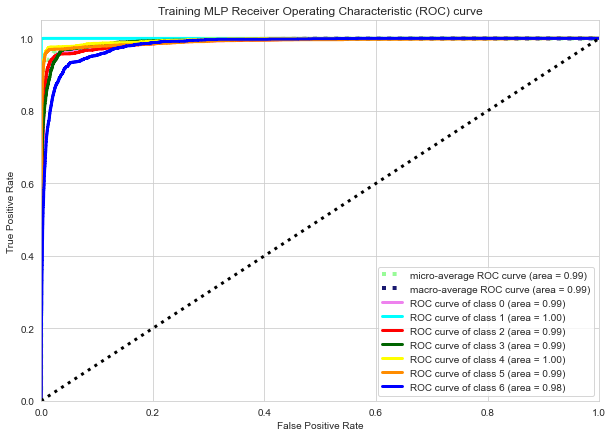

In [53]:
# ROC plot for MLP model train side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_train_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_train_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_train_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Training MLP Receiver Operating Characteristic (ROC) curve")
  plt.legend()

mlp_encoding = label_binarize(y_train_sm, classes=[0,1,2,3,4,5,6])
mlp_pre_proba = net_final_train.predict_proba(X_train_sm)
plot_roc_curve(mlp_encoding, mlp_pre_proba, 'final_mlp')

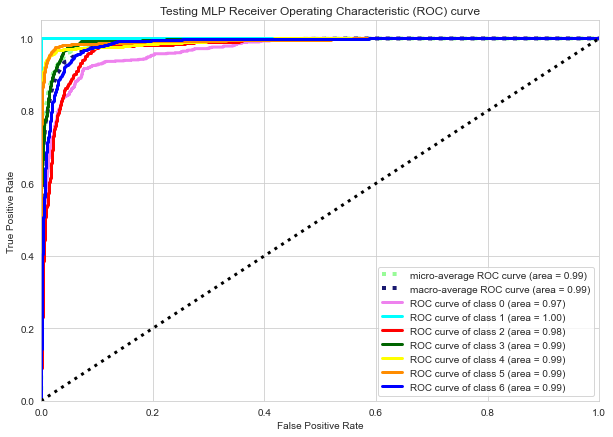

In [54]:
# ROC plot for MLP model test side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_test_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_test_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_test_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Testing MLP Receiver Operating Characteristic (ROC) curve")
  plt.legend()

mlp_encoding = label_binarize(y_test_sm, classes=[0,1,2,3,4,5,6])
mlp_pre_proba = net_final_test.predict_proba(X_test_sm)
plot_roc_curve(mlp_encoding, mlp_pre_proba, 'final_mlp')

In [63]:
# create the base SVM model
from sklearn.svm import SVC
classifier = OneVsRestClassifier(SVC(random_state=0))
#Fit the model for the data
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=0))

In [64]:
# training accuracy of the base SVM model
from sklearn.model_selection import cross_val_score
training_accuracies_svc = cross_val_score(estimator = classifier,X = X_train,y = y_train, cv = 5)
print("Training accuracy: {:.2f} %".format(training_accuracies_svc.mean()*100))

Training accuracy: 61.21 %


In [65]:
# testing accuracy of the base SVM model
from sklearn.model_selection import cross_val_score
testing_accuracies_svc = cross_val_score(estimator = classifier,X = X_test,y = y_test, cv = 5)
print("Testing accuracy: {:.2f} %".format(testing_accuracies_svc.mean()*100))

Testing accuracy: 61.40 %


In [66]:
# create the SVM model for scaled data
from sklearn.svm import SVC
classifier_sc = OneVsRestClassifier(SVC(random_state=0))
#Fit the model for the data
classifier_sc.fit(X_train_sc, y_train_sc)

OneVsRestClassifier(estimator=SVC(random_state=0))

In [67]:
# training accuracy of the SVM model for scaled data
from sklearn.model_selection import cross_val_score
training_accuracies_svc_sc = cross_val_score(estimator = classifier_sc,X = X_train_sc,y = y_train_sc, cv = 5)
print("Training accuracy SVC scaled data: {:.2f} %".format(training_accuracies_svc_sc.mean()*100))

Training accuracy SVC scaled data: 91.98 %


In [68]:
# testing accuracy of the SVM model for scaled data
from sklearn.model_selection import cross_val_score
testing_accuracies_svc_sc = cross_val_score(estimator = classifier_sc,X = X_test_sc,y = y_test_sc, cv = 5)
print("Testing accuracy SVC scaled data: {:.2f} %".format(testing_accuracies_svc_sc.mean()*100))

Testing accuracy SVC scaled data: 89.94 %


In [69]:
# create the SVM model for smote data
from sklearn.svm import SVC
classifier_sm = OneVsRestClassifier(SVC(random_state=0))
#Fit the model for the data
classifier_sm.fit(X_train_sm, y_train_sm)

OneVsRestClassifier(estimator=SVC(random_state=0))

In [70]:
# training accuracy of the SVM model for smote data
from sklearn.model_selection import cross_val_score
training_accuracies_svc_sm = cross_val_score(estimator = classifier_sm,X = X_train_sm,y = y_train_sm, cv = 5)
print("Training accuracy SVC smote data: {:.2f} %".format(training_accuracies_svc_sm.mean()*100))

Training accuracy SVC smote data: 93.96 %


In [71]:
# testing accuracy of the SVM model for smote data
from sklearn.model_selection import cross_val_score
testing_accuracies_svc_sm = cross_val_score(estimator = classifier_sm,X = X_test_sm,y = y_test_sm, cv = 5)
print("Testing accuracy SVC smote data: {:.2f} %".format(testing_accuracies_svc_sm.mean()*100))

Testing accuracy SVC smote data: 92.44 %


In [75]:
# selecting parameters for random grid search train side
kernel = ['linear','poly']
gamma = [0.01, 0.001, 0.0001]
degree = [1, 2, 3, 4, 5]
C = [0.1, 1, 10]
probability = [True, False]

rand_grid = {'kernel': kernel,'C': C,'degree': degree,'gamma': gamma,'probability': probability}

# random grid search for base SVM model
random_grid_search_train = RandomizedSearchCV(classifier_sm.estimator,param_distributions=rand_grid,
                     cv=5, verbose=0, random_state=0,refit=True)
random_grid_search_train.fit(X_train_sm, y_train_sm)

print("Best parameters:",random_grid_search_train.best_params_)

Best parameters: {'probability': False, 'kernel': 'linear', 'gamma': 0.001, 'degree': 1, 'C': 10}


In [77]:
# selecting parameters for random grid search test side
kernel = ['linear','poly']
gamma = [0.01, 0.001, 0.0001]
degree = [1, 2, 3, 4, 5]
C = [0.1, 1, 10]
probability = [True, False]

rand_grid = {'kernel': kernel,'C': C,'degree': degree,'gamma': gamma,'probability': probability}

# random grid search for base SVM model
random_grid_search_test = RandomizedSearchCV(classifier_sm.estimator,param_distributions=rand_grid,
                     cv=5, verbose=0, random_state=0,refit=True)
random_grid_search_test.fit(X_test_sm, y_test_sm)

print("Best parameters:",random_grid_search_test.best_params_)

Best parameters: {'probability': False, 'kernel': 'linear', 'gamma': 0.001, 'degree': 1, 'C': 10}


In [78]:
# selecting parameters for grid search train side
kernel = ['linear','poly']
gamma = [0.01, 0.001, 0.0001]
degree = [1, 2, 3, 4, 5]
C = [0.1, 1, 10]
probability = [True, False]

grid_params = {'kernel': kernel,'C': C,'degree': degree,'gamma': gamma,'probability': probability}

In [82]:
# grid search for base SVM model train side
grid_svc_train = GridSearchCV(classifier_sm.estimator, grid_params , refit = True, verbose = 3, cv = 5)
 
# fitting the model for grid search
grid_svc_train.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.926 total time=  19.7s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.930 total time=  20.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.930 total time=  19.6s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.936 total time=  20.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.934 total time=  19.9s
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, score=0.926 total time=   4.6s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, score=0.930 total time=   4.6s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, score=0.930 total time=   4.6s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, s

GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly'],
                         'probability': [True, False]},
             verbose=3)

In [83]:
# get best hyperparameters for SVM train side
print("Best parameters:",grid_svc_train.best_params_)

Best parameters: {'C': 10, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear', 'probability': True}


In [81]:
# grid search for base SVM model test side
grid_svc_test = GridSearchCV(classifier_sm.estimator, grid_params , refit = True, verbose = 3, cv = 5)
 
# fitting the model for grid search
grid_svc_test.fit(X_test_sm, y_test_sm)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.913 total time=   1.9s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.902 total time=   1.9s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.898 total time=   1.9s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.913 total time=   1.9s
[CV 5/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=True;, score=0.926 total time=   1.9s
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, score=0.913 total time=   0.4s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, score=0.902 total time=   0.4s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, score=0.898 total time=   0.4s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=linear, probability=False;, s

GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly'],
                         'probability': [True, False]},
             verbose=3)

In [84]:
# get best hyperparameters for SVM test side
print("Best parameters:",grid_svc_test.best_params_)

Best parameters: {'C': 10, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear', 'probability': True}


In [88]:
# final svm model obtained from applying best parameters from grid search
svc_final = OneVsRestClassifier(SVC(C=10, gamma=0.01,probability=True, random_state=0))

In [130]:
# exporting final svm model
with open('final_models/final_svm.pickle', 'wb') as output:
    pickle.dump(svc_final, output)

In [93]:
# training time for svc
start_time_train_svc = time.time()
svc_final.fit(X_train_sm,y_train_sm);
stop_time_train_svc = time.time() - start_time_train_svc
print('Training time for SVM :', stop_time_train_svc)

Training time for SVM : 312.8424618244171


In [94]:
# testing time for svc
start_time_test_svc = time.time()
svc_final.fit(X_test_sm,y_test_sm);
stop_time_test_svc = time.time() - start_time_test_svc
print('Testing time for SVM :', stop_time_test_svc)

Testing time for SVM : 19.24995493888855


In [95]:
# print final svm model classification report train side
print(classification_report(y_train_sm,svc_final.predict(X_train_sm)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2837
           1       1.00      1.00      1.00      2837
           2       0.83      0.91      0.87      2837
           3       0.79      0.94      0.86      2837
           4       0.89      0.96      0.92      2837
           5       0.92      0.95      0.93      2837
           6       0.96      0.48      0.64      2837

    accuracy                           0.89     19859
   macro avg       0.89      0.89      0.88     19859
weighted avg       0.89      0.89      0.88     19859



In [97]:
# print final svm model classification report test side
print(classification_report(y_test_sm,svc_final.predict(X_test_sm)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       709
           1       1.00      1.00      1.00       709
           2       0.83      0.92      0.87       709
           3       0.76      0.94      0.84       709
           4       0.90      0.94      0.92       709
           5       0.92      0.95      0.93       709
           6       0.97      0.47      0.63       709

    accuracy                           0.88      4963
   macro avg       0.89      0.88      0.87      4963
weighted avg       0.89      0.88      0.87      4963



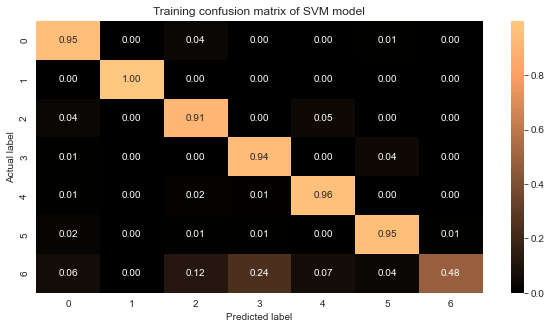

In [100]:
# train confusion matrix of the svm model
fig = plt.figure(figsize=(10,5))
con_matrix_train_svm = confusion_matrix(y_train_sm, svc_final.predict(X_train_sm))
# normalizing the data
con_matrix_train_svm = con_matrix_train_svm / np.sum(con_matrix_train_svm, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_train_svm,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Training confusion matrix of SVM model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

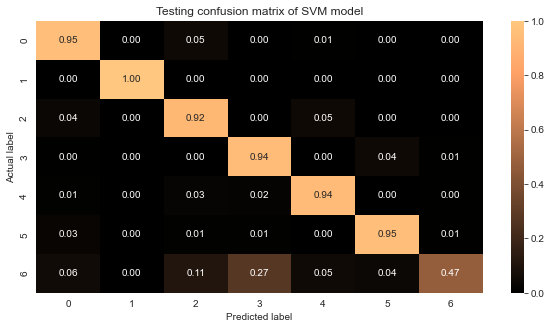

In [101]:
# test confusion matrix of the svm model
fig = plt.figure(figsize=(10,5))
con_matrix_test_svm = confusion_matrix(y_test_sm, svc_final.predict(X_test_sm))
# normalizing the data
con_matrix_test_svm = con_matrix_test_svm / np.sum(con_matrix_test_svm, axis=1, keepdims=True)
# creating heatmap for confusion matrix
sns.heatmap(con_matrix_test_svm,annot=True,cmap = 'copper' ,fmt='.2f')
plt.title('Testing confusion matrix of SVM model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [102]:
# training accuracy of the final SVM model cross validation
from sklearn.model_selection import cross_val_score
training_accuracies_svc_final = cross_val_score(estimator = svc_final,X = X_train_sm,y = y_train_sm, cv = 5)
print("Training accuracy: {:.2f} %".format(training_accuracies_svc_final.mean()*100))

Training accuracy: 91.52 %


In [103]:
# testing accuracy of the final SVM model cross validation
from sklearn.model_selection import cross_val_score
testing_accuracies_svc_final = cross_val_score(estimator = svc_final,X = X_test_sm,y = y_test_sm, cv = 5)
print("Testing accuracy: {:.2f} %".format(testing_accuracies_svc_final.mean()*100))

Testing accuracy: 87.63 %


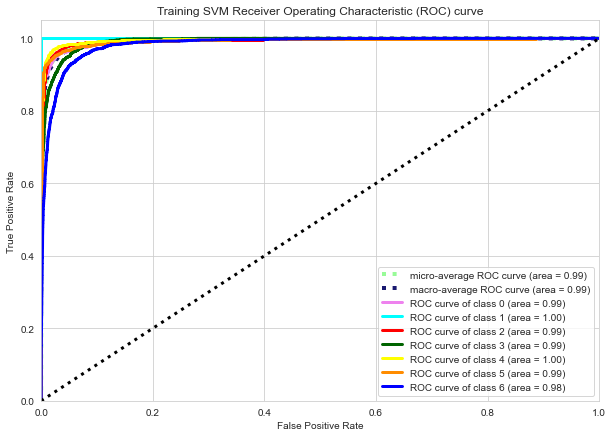

In [107]:
# ROC plot for SVM model train side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_train_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_train_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_train_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Training SVM Receiver Operating Characteristic (ROC) curve")
  plt.legend()

svm_encoding = label_binarize(y_train_sm, classes=[0,1,2,3,4,5,6])
svm_pre_proba = svc_final.predict_proba(X_train_sm)
plot_roc_curve(svm_encoding, svm_pre_proba, 'svc_final')

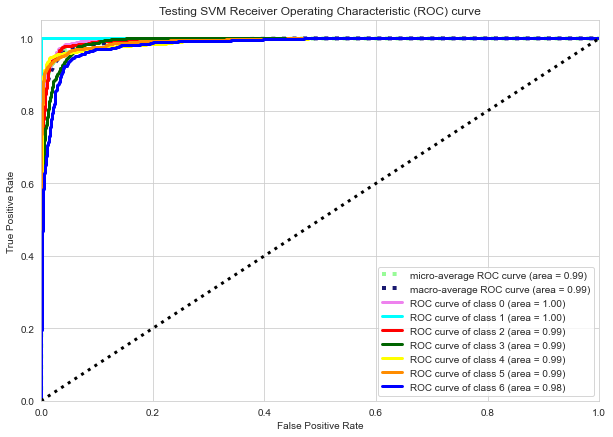

In [108]:
# ROC plot for SVM model train side
# referred from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(y_train_sm, y_pred_sm, model_sm):
  
  no_of_classes = 7

  # Compute ROC curve and ROC area for each class
  false_pos_r = dict()
  true_pos_r = dict()
  roc_auc = dict()
  for i in range(0,7):
    false_pos_r[i], true_pos_r[i], _ = roc_curve(y_train_sm[:, i], y_pred_sm[:, i])
    roc_auc[i] = auc(false_pos_r[i], true_pos_r[i])
  
  # Compute micro-average ROC curve and ROC area
  false_pos_r["micro_avg"], true_pos_r["micro_avg"], _ = roc_curve(y_train_sm.ravel(), y_pred_sm.ravel())
  roc_auc["micro_avg"] = auc(false_pos_r["micro_avg"], true_pos_r["micro_avg"])

  # First aggregate all false positive rates
  all_false_pos_r = np.unique(np.concatenate([false_pos_r[i] for i in range(0,7)]))

  # Then interpolate all ROC curves at this points
  mean_true_pos_r = np.zeros_like(all_false_pos_r)
  for i in range(0,7):
    mean_true_pos_r += np.interp(all_false_pos_r, false_pos_r[i], true_pos_r[i])

  # Finally average it and compute AUC
  mean_true_pos_r /= no_of_classes

  false_pos_r["macro_avg"] = all_false_pos_r
  true_pos_r["macro_avg"] = mean_true_pos_r
  roc_auc["macro_avg"] = auc(false_pos_r["macro_avg"], true_pos_r["macro_avg"])

  # Plot all ROC curves
  plt.figure(figsize=(10,7))
  colors = matplotlib.cm.get_cmap('tab20')
  colors = colors(np.linspace(0, 3, 7))
  lw = 3
  plt.plot(false_pos_r["micro_avg"], true_pos_r["micro_avg"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro_avg"]),
    color="palegreen", linestyle=":", linewidth=4)

  plt.plot(false_pos_r["macro_avg"], true_pos_r["macro_avg"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro_avg"]),
    color="midnightblue", linestyle=":", linewidth=4)

  colors = cycle(["violet","aqua","red","darkgreen", "yellow","darkorange", "blue"])
  for i, color in zip(range(0,7), colors):
    plt.plot(false_pos_r[i], true_pos_r[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k:", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Testing SVM Receiver Operating Characteristic (ROC) curve")
  plt.legend()

svm_encoding = label_binarize(y_test_sm, classes=[0,1,2,3,4,5,6])
svm_pre_proba = svc_final.predict_proba(X_test_sm)
plot_roc_curve(svm_encoding, svm_pre_proba, 'svc_final')

In [146]:
df_drybean1

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,3
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,3
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,3
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,3


In [148]:

from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df_drybean1, test_size=0.2,random_state=10)

In [150]:
training_data.to_csv('training_data.csv')

In [151]:
testing_data.to_csv('testing_data.csv')